# Анализ лояльности пользователей Яндекс Афиши

- Автор: Пётр Дудочкин
- Дата: 02.01.2026

## Цель и задачи  

**Цель:** Провести исследовательский анализ данных пользователей Яндекс Афиши, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - изучить данные более детально;
    - изучить взаимосвязь данных в столбце `days_since_prev` с другими данными.
4. Сформулировать выводы по проведённому анализу.


## Данные

Выгрузка из базы данных SQL `data-analyst-afisha` позволит собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используем данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используем данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.


## Структура проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных.
3. Создание профиля пользователя.
4. Исследовательский анализ данных.
5. Итоговые выводы.

---

## Этапы выполнения проекта

### Загрузка данных и знакомство с ними.

Для выгрузки используем запрос SQL-запрос к базе данных `data-analyst-afisha`, выгружающий в датафрейм pandas необходимые данные.

In [1]:
# Импортируем библиотеки
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import numpy as np

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

In [2]:
load_dotenv()
db_config = {'user': os.getenv('user'),
             'pwd': os.getenv('password'),
             'host': os.getenv('host'),
             'port': os.getenv('port'),
             'db': os.getenv('db')
             }

# Проверяем, что все переменные загружены
for key, value in db_config.items():
    if value is None:
        raise ValueError(f"Переменная окружения для '{key}' не найдена в .env файле")

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

In [3]:
query = '''
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT 
    user_id, 
    device_type_canonical,
    order_id,
    created_dt_msk AS order_dt,
    created_ts_msk AS order_ts,
    currency_code,
    revenue,
    tickets_count,
    EXTRACT(day FROM (created_dt_msk - (LAG(created_dt_msk) over (partition by user_id order by created_dt_msk)))) as days_since_prev,
    p.event_id,
    service_name,
    event_type_main,
    region_name,
    city_name
FROM afisha.purchases p
JOIN afisha.events e ON p.event_id=e.event_id
JOIN afisha.city c ON e.city_id=c.city_id
JOIN afisha.regions r ON c.region_id=r.region_id
WHERE (device_type_canonical = 'mobile' or device_type_canonical = 'desktop') and event_type_main != 'фильм'
ORDER BY user_id
'''

# Выгружаем данные в переменную df
df = pd.read_sql_query(query, con=engine)
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

Датасет `df` содержит 14 столбцов и 290611 строк, в которых представлена информация об использовании платформы пользователями.

После первичного анализа данных можно сделать следующие выводы:
- Названия столбцов представлены в виде snake case.
- Пропуски содержатся только в столбце `days_since_prev`, что характерно для пользователей с одной покупкой. Однако следует проверить и другие столбцы: в них могут встречаться значения-индикаторы, которые будут говорить об отсутствии данных.
- Значения в столбцах соответствуют своему описанию.
- Данные во всех столбцах соответствуют выбранному типах данных (тип данных не нуждается в корректировке), кроме `days_since_prev` - тип можно изменить с `float64` на `int64`.

### Предобработка данных

Проверим данные на наличие явных и неявных дубликатов.

In [73]:
# Проверим данные на наличие полных дубликатов
print(df.duplicated().sum())

0


In [6]:
# Проверяем уникальные значения в столбцах
for column in ['device_type_canonical', 'currency_code', 'service_name', 'event_type_main', 'region_name', 'city_name']:
    print(f'Уникальные значения в столбце {column}:')
    print(df[column].sort_values().unique())
    print()

Уникальные значения в столбце device_type_canonical:
['desktop' 'mobile']

Уникальные значения в столбце currency_code:
['kzt' 'rub']

Уникальные значения в столбце service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']

Уникальные значения в столбце event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Уникальные значения в столбце region_name:
['Белоярская область' 'Берестовский округ' 'Берёзовская область'
 'Боровлянский край' 'Верховинская область' 'Верхозёрский край'
 'Верхоречная о

Дубликатов не обнаружено, но некоторые заказы были оплачены в валюте `kzt`, а другие в `rub`. Приведём данные к единой валюте - российскому рублю. 

In [7]:
currency_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [8]:
currency_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [9]:
currency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [10]:
currency_df['data'] = currency_df['data'].astype('datetime64[ns]')

In [11]:
# Соединяем данные в единый датафрейм df1
df1 = df.merge(currency_df, how = 'left', left_on=['order_dt', 'currency_code'], right_on=['data', 'cdx'])

In [12]:
def kzt_to_rub(row):
    if row['currency_code'] == 'kzt':
        return round(row['revenue']*row['curs']/row['nominal'], 2)
    elif row['currency_code'] == 'rub':
        return row['revenue']
    else:
        return None
    
df1['revenue_rub'] = df1.apply(kzt_to_rub, axis = 1)

In [13]:
df1.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,data,nominal,curs,cdx,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,Край билетов,театр,Каменевский регион,Глиногорск,NaT,NaN,NaN,NaN,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,Мой билет,выставки,Каменевский регион,Глиногорск,NaT,NaN,NaN,NaN,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,За билетом!,другое,Каменевский регион,Глиногорск,NaT,NaN,NaN,NaN,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,Лови билет!,другое,Североярская область,Озёрск,NaT,NaN,NaN,NaN,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,NaT,NaN,NaN,NaN,1390.41


Преобразуем тип данных столбца `days_since_prev` с `float64` на `Int64`.
Также удалим не нужные больше столбцы `data`, `nominal`, `curs`, `cdx`.

In [14]:
df1['days_since_prev'] = df1['days_since_prev'].astype('Int64')
df = df1.drop(['data', 'nominal', 'curs', 'cdx'], axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  Int64         
 9   event_id               290611 non-null  int64         
 10  service_name           290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  region_name            290611 non-null  obje

In [16]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,<NA>,169230,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,<NA>,237325,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75,578454,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,<NA>,387271,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83,509453,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


In [17]:
# Проверяем распределение данных по значениям столбцов

for column in ['device_type_canonical', 'currency_code', 'tickets_count', 'days_since_prev', 'service_name', 'event_type_main', 'region_name', 'city_name']:
    print(f'Распределение данных по значениям столбца {column}:')
    print(df[column].value_counts(), f'\n')

Распределение данных по значениям столбца device_type_canonical:
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64 

Распределение данных по значениям столбца currency_code:
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64 

Распределение данных по значениям столбца tickets_count:
tickets_count
3     92247
2     83807
4     54812
1     41798
5     13476
6      4283
7        62
9        38
8        21
10       19
11       13
13        7
17        6
19        5
12        4
14        4
15        2
27        2
30        2
47        1
57        1
37        1
Name: count, dtype: int64 

Распределение данных по значениям столбца days_since_prev:
days_since_prev
0      184052
1       30472
2        9947
3        6182
4        4410
        ...  
148         3
143         3
147         3
141         2
140         1
Name: count, Length: 149, dtype: Int64 

Распределение данных по значениям столбца service_name:
service_name
Билеты без проблем  

In [18]:
# Изучаем статистические показатели столбца revenue_rub
print('Статистические показатели столбца revenue_rub:')
df['revenue_rub'].describe()

Статистические показатели столбца revenue_rub:


count    290611.000000
mean        555.571989
std         875.498170
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Выручка с продажи некоторых билетов отрицательная. Это может являться признаком проведения рекламных кампаний или благотворительных акций, в рамках которых оператор продаёт билеты ниже себестоимости, без конкретных указаний заказчика считать подобные данные выбросом нельзя.

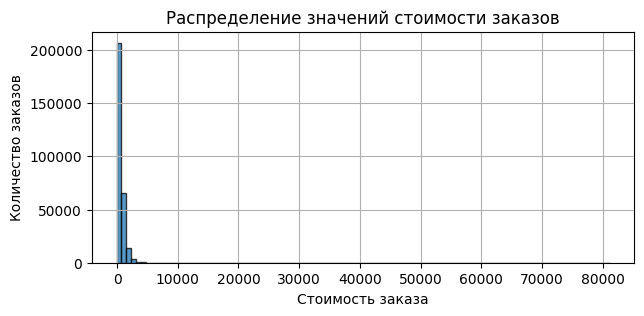

In [19]:
# Строим гистограмму распределения стоимости заказов

plt.figure(figsize=(7, 3))

df['revenue_rub'].plot(
                kind='hist',
                bins=100,
                alpha=0.75,
                edgecolor='black',
                rot=0,
)

plt.title('Распределение значений стоимости заказов')
plt.xlabel('Стоимость заказа')
plt.ylabel('Количество заказов')

plt.grid()

plt.show()

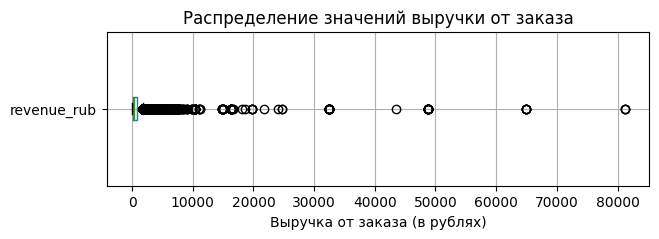

In [20]:
# Строим диаграмму размаха значений в столбце revenue_rub
plt.figure(figsize=(7, 2))

df.boxplot(column='revenue_rub', vert=False)

plt.title('Распределение значений выручки от заказа')
plt.xlabel('Выручка от заказа (в рублях)')

plt.show()

Распределение данных выглядит положительно асимметричным, максимальное значение гораздо больше медианы. Большинство заказов расположено в пределах 10000 руб., более высокие значения можно отнести к выбросам.
Отфильтруем значения столбца `revenue_rub` по 99 перцентилю.

In [21]:
percentile_99 = df['revenue_rub'].quantile(0.99)
df2 = df[df['revenue_rub'] <= percentile_99]

In [22]:
# Изучаем статистические показатели отфильтрованного столбца revenue_rub
print('Статистические показатели столбца revenue_rub:')
df2['revenue_rub'].describe()

Статистические показатели столбца revenue_rub:


count    287786.000000
mean        518.029227
std         511.963781
min         -90.760000
25%         111.850000
50%         343.850000
75%         788.660000
max        2628.420000
Name: revenue_rub, dtype: float64

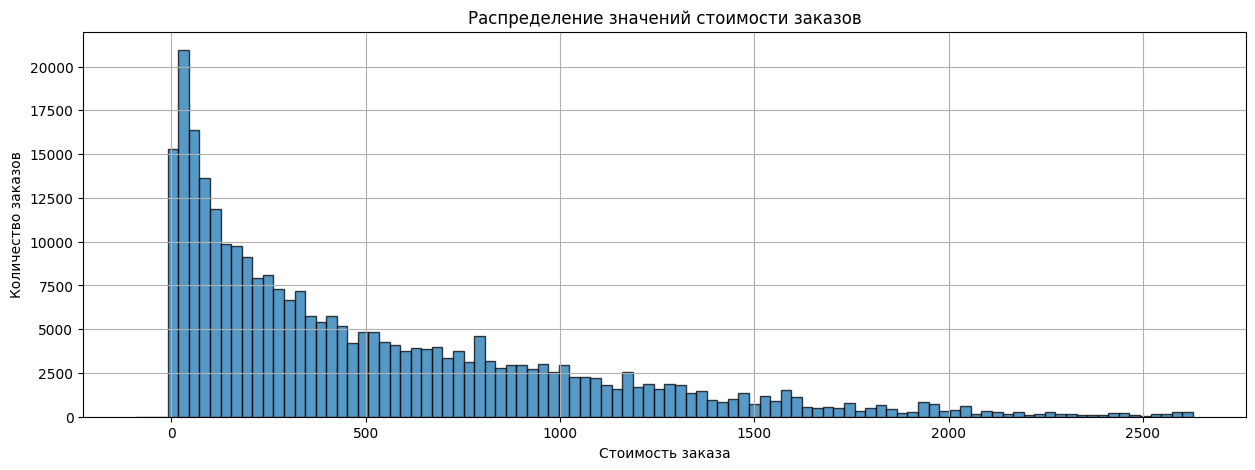

In [23]:
# Строим гистограмму распределения стоимости заказов
plt.figure(figsize=(15, 5))

df2['revenue_rub'].plot(
                kind='hist',
                bins=100,
                alpha=0.75,
                edgecolor='black',
                rot=0,
)

plt.title('Распределение значений стоимости заказов')
plt.xlabel('Стоимость заказа')
plt.ylabel('Количество заказов')

plt.grid()

plt.show()

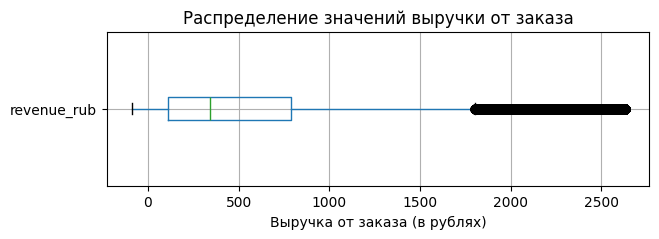

In [24]:
# Строим диаграмму размаха значений в столбце revenue_rub
plt.figure(figsize=(7, 2))

df2.boxplot(column='revenue_rub', vert=False)

plt.title('Распределение значений выручки от заказа')
plt.xlabel('Выручка от заказа (в рублях)')

plt.show()

In [25]:
# Изучаем статистические показатели столбца tickets_count
print('Статистические показатели столбца tickets_count:')
df2['tickets_count'].describe()

Статистические показатели столбца tickets_count:


count    287786.000000
mean          2.740495
std           1.163073
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

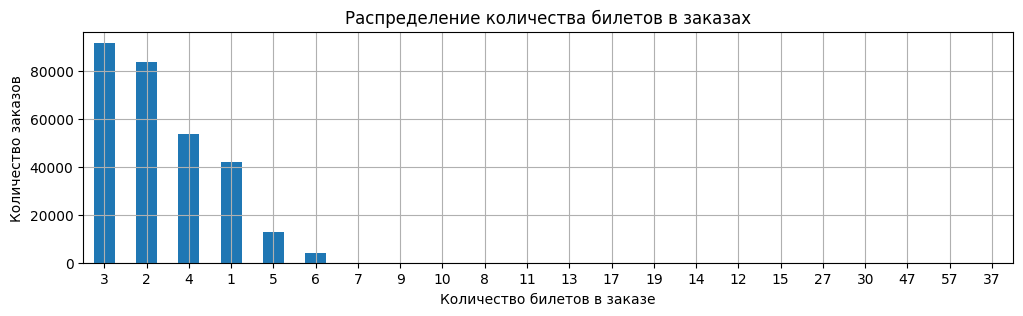

In [26]:
# Строим столбчатую диаграмму распределение количества билетов в заказах
plt.figure(figsize=(12, 3))

df2['tickets_count'].value_counts().plot(
               kind='bar',
               rot=0,
               legend=False,
               title=f'Распределение количества билетов в заказах'
)

plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')

plt.grid()
plt.show()

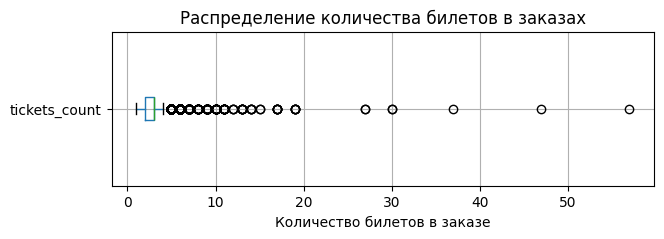

In [27]:
# Строим диаграмму размаха значений в столбце tickets_count
plt.figure(figsize=(7, 2))

df2.boxplot(column='tickets_count', vert=False)

plt.title('Распределение количества билетов в заказах')
plt.xlabel('Количество билетов в заказе')

plt.show()

In [28]:
# Проверяем распределение данных в столбце tickets_count
print("Количество билетов | Количество заказов\n")
print(df2['tickets_count'].value_counts())

Количество билетов | Количество заказов

tickets_count
3     91724
2     83649
4     53642
1     41788
5     12858
6      3945
7        58
9        38
10       19
8        18
11       13
13        7
17        6
19        5
14        4
12        3
15        2
27        2
30        2
47        1
57        1
37        1
Name: count, dtype: int64


Распределение данных выглядит положительно асимметричным. Хотя большинство заказов сделано на 11 билетов и менее, заказы на большее количество (вплот до максимального - 57) нельзя считать выбросами, т.к. вероятно заказы были сделаны на организованную группу (например, корпоративное мероприятие).

In [29]:
# Оценка объёма отфильтрованных данных
filtered = round((1-df2.shape[0]/df.shape[0])*100, 2)
print(f'В ходе очистки данных от выбросов было отфильтровано {filtered}%.')

В ходе очистки данных от выбросов было отфильтровано 0.97%.


In [30]:
# Изучаем статистические показатели столбца days_since_prev
print('Статистические показатели столбца days_since_prev:')
df2['days_since_prev'].describe()

Статистические показатели столбца days_since_prev:


count     266050.0
mean      3.223488
std      11.353818
min            0.0
25%            0.0
50%            0.0
75%            1.0
max          148.0
Name: days_since_prev, dtype: Float64

In [31]:
nevermore = round(df2['days_since_prev'].isna().sum()/df2.shape[0]*100, 2)
print(f'Доля заказов пользователей, совершивших покупку единожды: {nevermore}%.')

Доля заказов пользователей, совершивших покупку единожды: 7.55%.


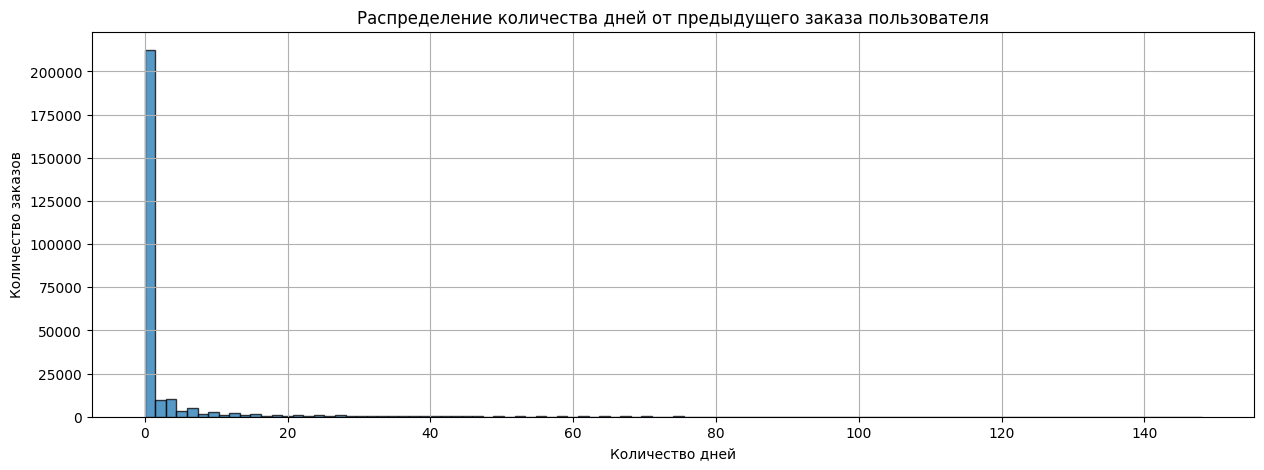

In [32]:
# Строим гистограмму распределения количества дней от предыдущего заказа пользователя
plt.figure(figsize=(15, 5))

df2['days_since_prev'].plot(
                kind='hist',
                bins=100,
                alpha=0.75,
                edgecolor='black',
                rot=0,
)

plt.title('Распределение количества дней от предыдущего заказа пользователя')
plt.xlabel('Количество дней')
plt.ylabel('Количество заказов')

plt.grid()

plt.show()

In [33]:
# Проверяем распределение данных в столбце days_since_prev
print("Количество дней с предыдущего заказа | Количество заказов\n")
print(df2['days_since_prev'].value_counts())

Количество дней с предыдущего заказа | Количество заказов

days_since_prev
0      182206
1       30213
2        9856
3        6127
4        4360
        ...  
148         3
143         3
147         3
141         2
140         1
Name: count, Length: 149, dtype: Int64


In [34]:
df2['days_since_prev'].value_counts().head(60)

days_since_prev
0     182206
1      30213
2       9856
3       6127
4       4360
5       3366
6       2701
7       2376
8       1830
9       1616
10      1384
11      1156
12      1051
13      1011
14       871
15       855
16       764
17       663
18       659
19       592
20       580
21       519
22       467
23       455
24       447
25       388
27       370
26       361
28       348
30       321
29       320
31       294
32       288
33       277
34       249
35       243
36       222
37       220
41       206
38       203
39       185
40       183
44       178
43       172
42       171
45       156
46       150
49       136
53       135
48       128
52       128
55       114
51       111
50       111
59       105
56       104
47       103
58        97
54        94
60        92
Name: count, dtype: Int64

Подавляющее большинство повторных заказов было сделано в тот же день, что и предыдущий. Максимальное временной промежуток между заказами одного пользователя - 148 дней, что вполне возможно и нельзя рассматривать как выброс.

**Промежуточные выводы**
- В ходе выгрузки данных был создан столбец `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено.
- Тип данных столбца `days_since_prev` был преобразован из `float64` в `Int64`.
- Все заказы быле приведены к одной валюте - российскому рублю, для чего был создан столбец `revenue_rub`.
- Дубликатов строк не обнаружено.
- В ходе очистки данных от выбросов было отфильтровано 0.97% заказов.

### Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас необъодимо построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

Построим профиль пользователя — для каждого пользователя найдём:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия;
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавим два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.


In [35]:
df_users = df2.sort_values('order_dt').groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    first_order_device=('device_type_canonical', 'first'),
    first_order_region=('region_name', 'first'),
    first_service_name=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    orders_count=('order_id', 'count'),
    mean_revenue=('revenue_rub', 'mean'),
    mean_tickets_count=('tickets_count', 'mean'),
    mean_days_since_prev=('days_since_prev', 'mean')
).reset_index()

df_users['mean_revenue'] = df_users['mean_revenue'].round(2)
df_users['mean_tickets_count'] = df_users['mean_tickets_count'].round(2)

# Добавим столбец is_two — 2 и более заказов
df_users['is_two'] = False
df_users.loc[df_users['orders_count'] >= 2, 'is_two'] = True

# Добавим столбец is_five — 5 и более заказов
df_users['is_five'] = False
df_users.loc[df_users['orders_count'] >= 5, 'is_five'] = True

In [36]:
display(df_users)

,user_id,first_order_dt,last_order_dt,first_order_device,first_order_region,first_service_name,first_event_type,orders_count,mean_revenue,mean_tickets_count,mean_days_since_prev,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.94,4.00,<NA>,False,False
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.01,3.00,75.0,True,False
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.21,2.67,51.0,True,False
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.83,4.00,<NA>,False,False
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.31,1.50,16.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21849,fff13b79bd47d7c,2024-07-16,2024-10-31,mobile,Каменевский регион,Мой билет,другое,9,688.04,2.56,13.375,True,True
21850,fff32fc9ad0f9f6,2024-08-15,2024-10-28,desktop,Каменевский регион,Билеты без проблем,стендап,2,851.00,2.50,74.0,True,False
21851,fffcd3dde79eb2c,2024-06-20,2024-10-30,desktop,Каменевский регион,Билеты без проблем,концерты,33,557.91,2.79,4.125,True,True
21852,fffeeb3c120cf0b,2024-09-24,2024-09-24,desktop,Широковская область,Билеты без проблем,стендап,1,661.53,2.00,<NA>,False,False


Используя данные о профилях пользователей, рассчитаем:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучим статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

In [37]:
total_users = df_users.shape[0]
print(f'В выборке всего {total_users} пользователей.')

mean_user_revenue = df_users.mean_revenue.mean().round(2)
print(f'Cредняя выручка с одного заказ пользователя составляет {mean_user_revenue} руб.')

В выборке всего 21854 пользователей.
Cредняя выручка с одного заказ пользователя составляет 544.4 руб.


In [38]:
two_orders_users_rate = round(df_users['is_two'].sum()/total_users*100, 2)
five_orders_users_rate = round(df_users['is_five'].sum()/total_users*100, 2)

print(f'Доля пользователей с 2 заказами и более составляет {two_orders_users_rate}%') 
print(f'Доля пользователей с 5 заказами и более составляет {five_orders_users_rate}%') 

Доля пользователей с 2 заказами и более составляет 61.71%
Доля пользователей с 5 заказами и более составляет 29.01%


In [39]:
# Изучаем статистические показатели по общему числу заказов

print('Cтатистические показатели по общему числу заказов пользователя')
df_users['orders_count'].describe()

Cтатистические показатели по общему числу заказов пользователя


count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10181.000000
Name: orders_count, dtype: float64

In [40]:
print('Cтатистические показатели по среднему числу билетов в заказе пользователя')
df_users['mean_tickets_count'].describe()

Cтатистические показатели по среднему числу билетов в заказе пользователя


count    21854.000000
mean         2.743136
std          0.913090
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: mean_tickets_count, dtype: float64

In [41]:
print('Cтатистические показатели по среднему количеству дней между покупками пользователя')
df_users['mean_days_since_prev'].describe()

Cтатистические показатели по среднему количеству дней между покупками пользователя


count      13513.0
mean     15.851275
std      22.306224
min            0.0
25%            1.0
50%            8.0
75%      20.428571
max          148.0
Name: mean_days_since_prev, dtype: Float64

Маскимальное количество заказов очень сильно отличается от медианы и выглядит как выброс: 10181 заказ пользователя при медианном значениии в 2. 

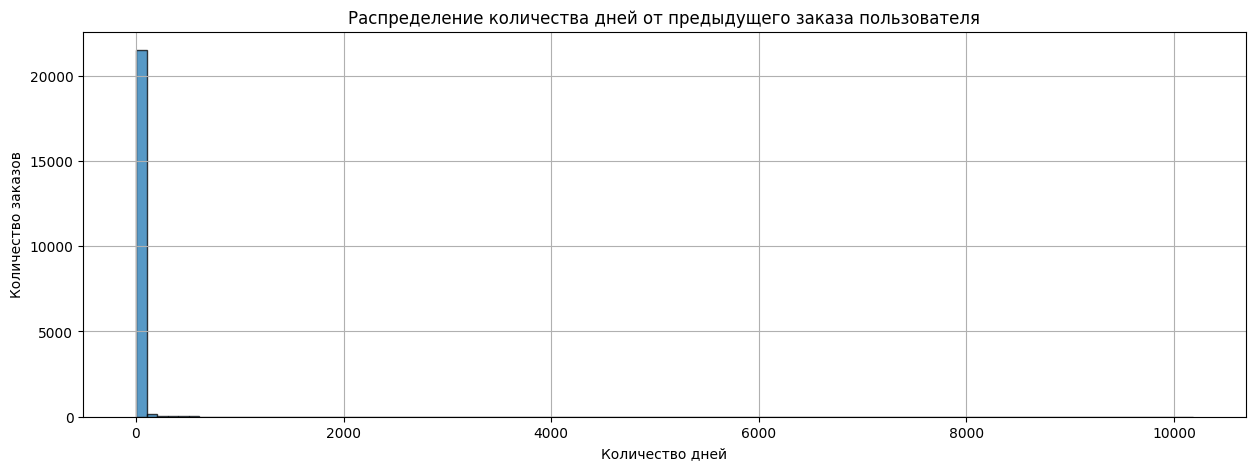

In [42]:
# Строим гистограмму распределения количества дней от предыдущего заказа пользователя
plt.figure(figsize=(15, 5))

df_users['orders_count'].plot(
                kind='hist',
                bins=100,
                alpha=0.75,
                edgecolor='black',
                rot=0,
)

plt.title('Распределение количества дней от предыдущего заказа пользователя')
plt.xlabel('Количество дней')
plt.ylabel('Количество заказов')

plt.grid()

plt.show()

In [43]:
df_users['orders_count'].value_counts().head(60)

orders_count
1     8368
2     3572
3     2175
4     1400
5      971
6      700
7      542
8      455
9      384
10     291
11     231
12     198
13     155
14     154
16     136
15     124
17     107
18      85
21      78
19      72
20      69
24      69
22      68
25      60
23      54
26      53
27      51
28      46
29      36
34      31
31      31
32      28
37      27
30      26
33      25
38      24
39      22
42      22
48      21
35      21
36      21
40      19
45      19
41      19
44      18
46      18
57      18
53      17
51      17
56      16
50      16
49      15
59      13
58      13
43      13
65      12
54      12
68      11
71      11
83       9
Name: count, dtype: int64

Отфильтруем данные по 99-му перцентилю.


In [44]:
orders_count_percentile_99 = df_users['orders_count'].quantile(0.99)
df_users2 = df_users[df_users['orders_count'] <= orders_count_percentile_99]

print('Cтатистические показатели по общему числу заказов пользователя (фильтрация данных по 99-му перцентилю)')
df_users2['orders_count'].describe()

Cтатистические показатели по общему числу заказов пользователя (фильтрация данных по 99-му перцентилю)


count    21638.000000
mean         6.501294
std         14.324031
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: orders_count, dtype: float64

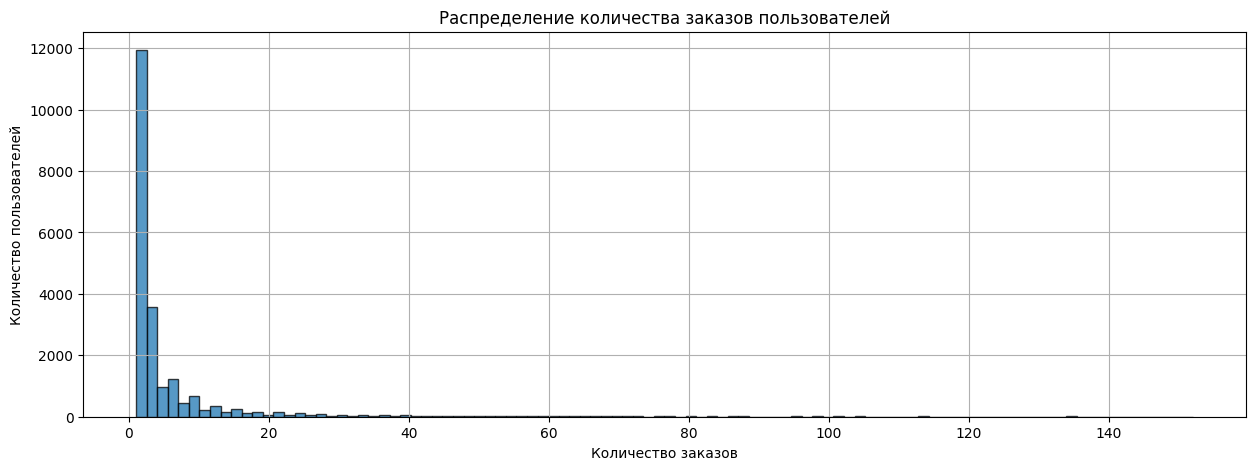

In [45]:
# Строим гистограмму распределения количества заказов пользователей
plt.figure(figsize=(15, 5))

df_users2['orders_count'].plot(
                kind='hist',
                bins=100,
                alpha=0.75,
                edgecolor='black',
                rot=0,
)

plt.title('Распределение количества заказов пользователей')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')

plt.grid()

plt.show()

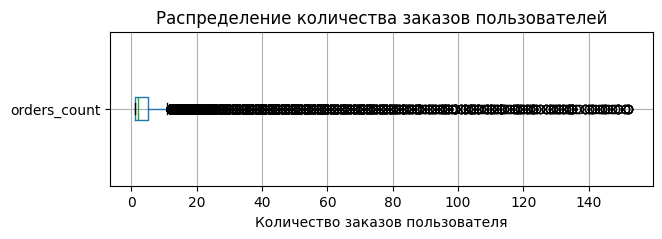

In [46]:
# Строим диаграмму размаха значений в столбце orders_count
plt.figure(figsize=(7, 2))

df_users2.boxplot(column='orders_count', vert=False)

plt.title('Распределение количества заказов пользователей')
plt.xlabel('Количество заказов пользователя')

plt.show()

Максимальное значение многократно превышает среднее, такие данные не подходят для описания типичного профиля пользователя.
Попробуем отфильтровать данные по 95-му перцентилю.

In [47]:
orders_count_percentile_95 = df_users['orders_count'].quantile(0.95)
df_users3 = df_users[df_users['orders_count'] <= orders_count_percentile_95]

print('Cтатистические показатели по общему числу заказов пользователя (фильтрация данных по 95-му перцентилю)')
df_users3['orders_count'].describe()

Cтатистические показатели по общему числу заказов пользователя (фильтрация данных по 95-му перцентилю)


count    20761.000000
mean         4.049564
std          5.113359
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         31.000000
Name: orders_count, dtype: float64

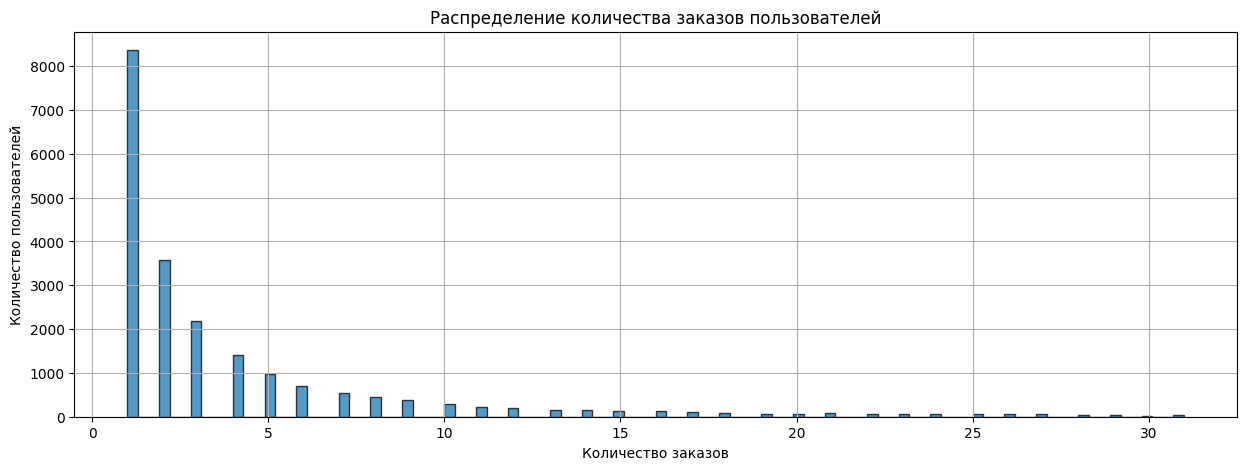

In [48]:
# Строим гистограмму распределения количества заказов пользователей
plt.figure(figsize=(15, 5))

df_users3['orders_count'].plot(
                kind='hist',
                bins=100,
                alpha=0.75,
                edgecolor='black',
                rot=0,
)

plt.title('Распределение количества заказов пользователей')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')

plt.grid()

plt.show()

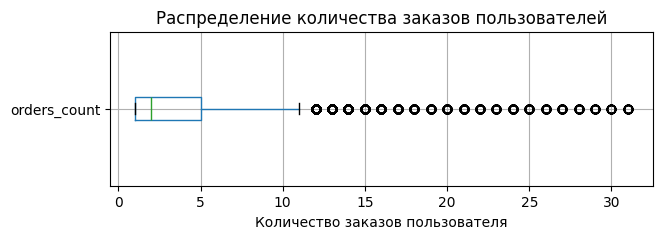

In [49]:
# Строим диаграмму размаха значений в столбце orders_count
plt.figure(figsize=(7, 2))

df_users3.boxplot(column='orders_count', vert=False)

plt.title('Распределение количества заказов пользователей')
plt.xlabel('Количество заказов пользователя')

plt.show()

In [50]:
# Оценка объёма отфильтрованных данных
filtered_users = round((1-df_users3.shape[0]/df_users.shape[0])*100, 2)
print(f'В ходе очистки данных от выбросов было отфильтровано {filtered_users}% пользователей.')

В ходе очистки данных от выбросов было отфильтровано 5.0% пользователей.


После фильтрации размер выборки сократился, но она стала более релевантной для анализа.

In [51]:
print('Статистические данные выборки после фильтрации:\n')

total_users = df_users3.shape[0]
print(f'В выборке всего {total_users} пользователей.')

mean_user_revenue = df_users3.mean_revenue.mean().round(2)
print(f'Cредняя выручка с одного заказ пользователя составляет {mean_user_revenue} руб.')

two_orders_users_rate = round(df_users3['is_two'].sum()/total_users*100, 2)
five_orders_users_rate = round(df_users3['is_five'].sum()/total_users*100, 2)
print(f'Доля пользователей с 2 заказами и более составляет {two_orders_users_rate}%') 
print(f'Доля пользователей с 5 заказами и более составляет {five_orders_users_rate}%') 

Статистические данные выборки после фильтрации:

В выборке всего 20761 пользователей.
Cредняя выручка с одного заказ пользователя составляет 546.68 руб.
Доля пользователей с 2 заказами и более составляет 59.69%
Доля пользователей с 5 заказами и более составляет 25.27%


### Исследовательский анализ данных

#### Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуем признаки, описывающие первый заказ пользователя, и выясним, влияют ли они на вероятность возвращения пользователя.

Изучим распределение пользователей по признакам.

- Сгруппируем пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
       
- Подсчитаем общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. 
- Оценим распределение пользователей по сегментам и наличие выраженных «точек входа» — сегментов с наибольшим числом пользователей.

In [52]:
# Подсчитаем доли пользователей по сегментам в разрезе признака повторной покупки 
for feature in ['first_event_type', 'first_order_device', 'first_order_region', 'first_service_name']:
    print(f'\033[1mРаспределение данных по значениям столбца {feature}\033[0m\n\nОбщее количество пользователей в каждом сегменте:')
    total = df_users3[feature].value_counts()
    print(total, f'\n\nДоля в разрезе признака')
    
    grouped = df_users3.groupby(feature)['is_two'].value_counts(normalize=True).round(2).unstack(fill_value=0)
    grouped = grouped.sort_values(by=True, ascending=False)
    print(grouped, f'\n\n')

Распределение данных по значениям столбца first_event_type

Общее количество пользователей в каждом сегменте:
first_event_type
концерты    9192
другое      5182
театр       4062
стендап     1065
спорт        768
выставки     399
ёлки          93
Name: count, dtype: int64 

Доля в разрезе признака
is_two            False  True 
first_event_type              
выставки           0.37   0.63
театр              0.38   0.62
концерты           0.40   0.60
стендап            0.41   0.59
другое             0.42   0.58
ёлки               0.45   0.55
спорт              0.46   0.54 


Распределение данных по значениям столбца first_order_device

Общее количество пользователей в каждом сегменте:
first_order_device
mobile     17202
desktop     3559
Name: count, dtype: int64 

Доля в разрезе признака
is_two              False  True 
first_order_device              
desktop              0.38   0.62
mobile               0.41   0.59 


Распределение данных по значениям столбца first_order_region

Общее 

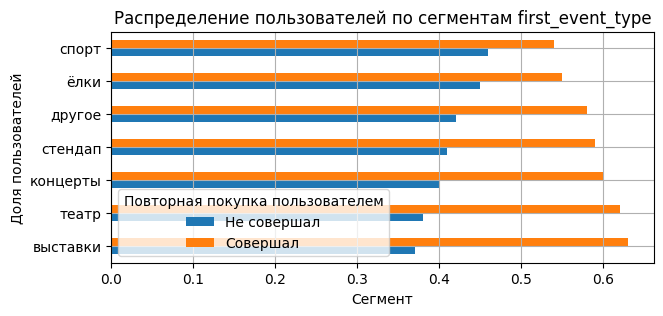

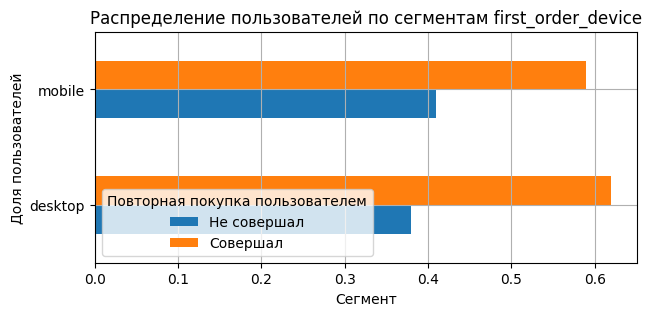

In [53]:
for feature in ['first_event_type', 'first_order_device']:
    grouped = df_users3.groupby(feature)['is_two'].value_counts(normalize=True).round(2).unstack(fill_value=0)
    grouped = grouped.sort_values(by=True, ascending=False)
    
    grouped.plot(kind='barh',
               title=f'Распределение пользователей по сегментам {feature}',
               legend=True,
               ylabel='Доля пользователей',
               xlabel='Сегмент',
               rot=0,
               figsize=(7, 3))
    
    plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем', loc='lower left')
    plt.grid()
    plt.show()

Распределение пользователей по сегментам типа первого мероприятия, а также первого использованного устройства, относительно равномерное.

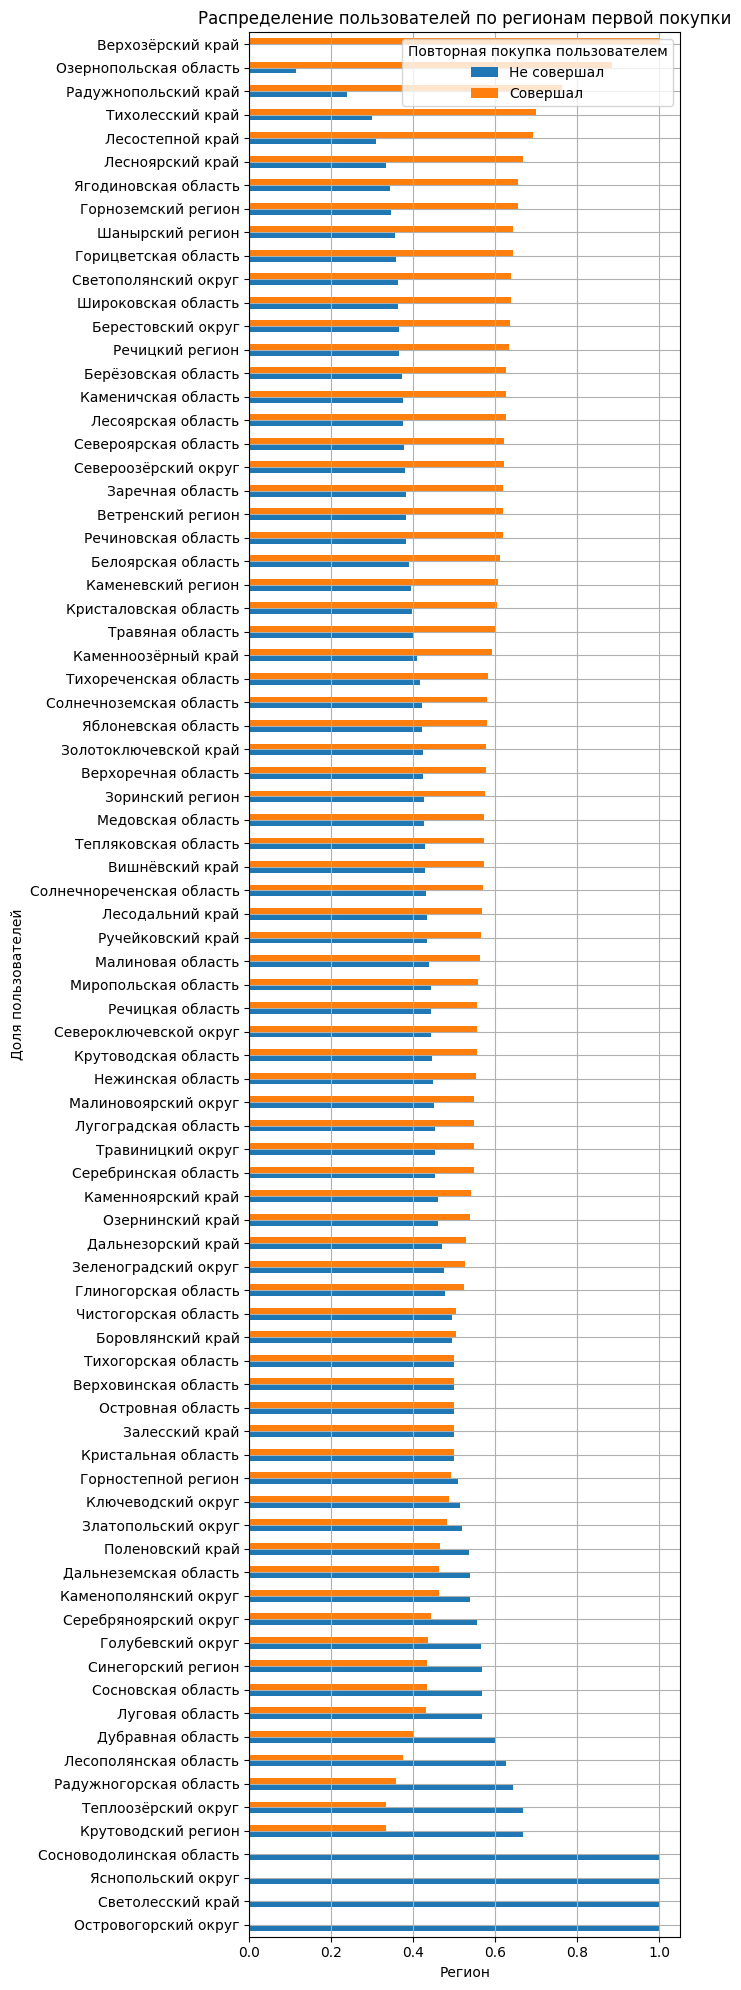

In [54]:
grouped = df_users3.groupby('first_order_region')['is_two'].value_counts(normalize=True).round(3).unstack(fill_value=0)
grouped = grouped.sort_values(by=True, ascending=True)

grouped.plot(kind='barh',
             title=f'Распределение пользователей по регионам первой покупки',
             legend=True,
             ylabel='Доля пользователей',
             xlabel='Регион',
             rot=0,
             figsize=(7, 20))

plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем')
plt.grid()
plt.tight_layout()
plt.show()

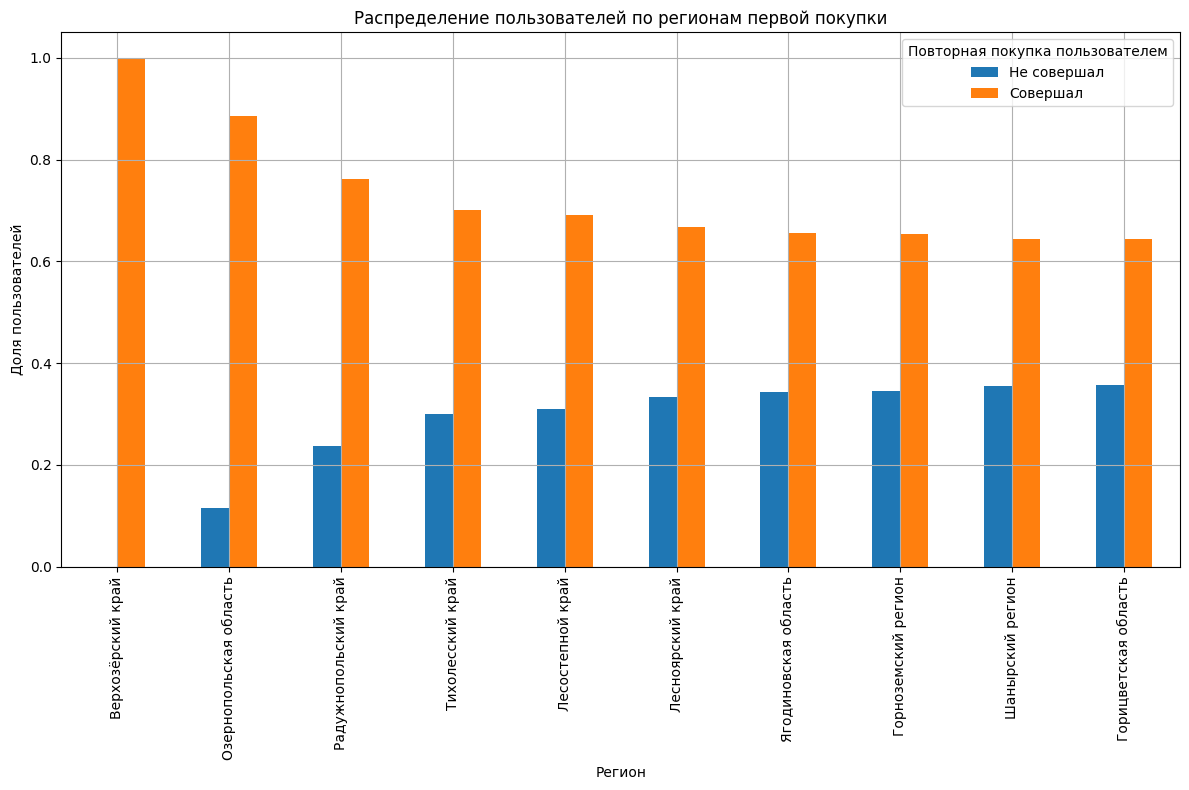

In [55]:
# Сегментов слишком много, для наглядности поместим на график только 10 сегментов с наибольшим количеством пользователей

grouped = df_users3.groupby('first_order_region')['is_two'].value_counts(normalize=True).round(3).unstack(fill_value=0)
grouped = grouped.sort_values(by=True, ascending=False).head(10)

grouped.plot(kind='bar',
             title=f'Распределение пользователей по регионам первой покупки',
             legend=True,
             ylabel='Доля пользователей',
             xlabel='Регион',
             rot=90,
             figsize=(12, 8))

plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем')
plt.grid()
plt.tight_layout()
plt.show()

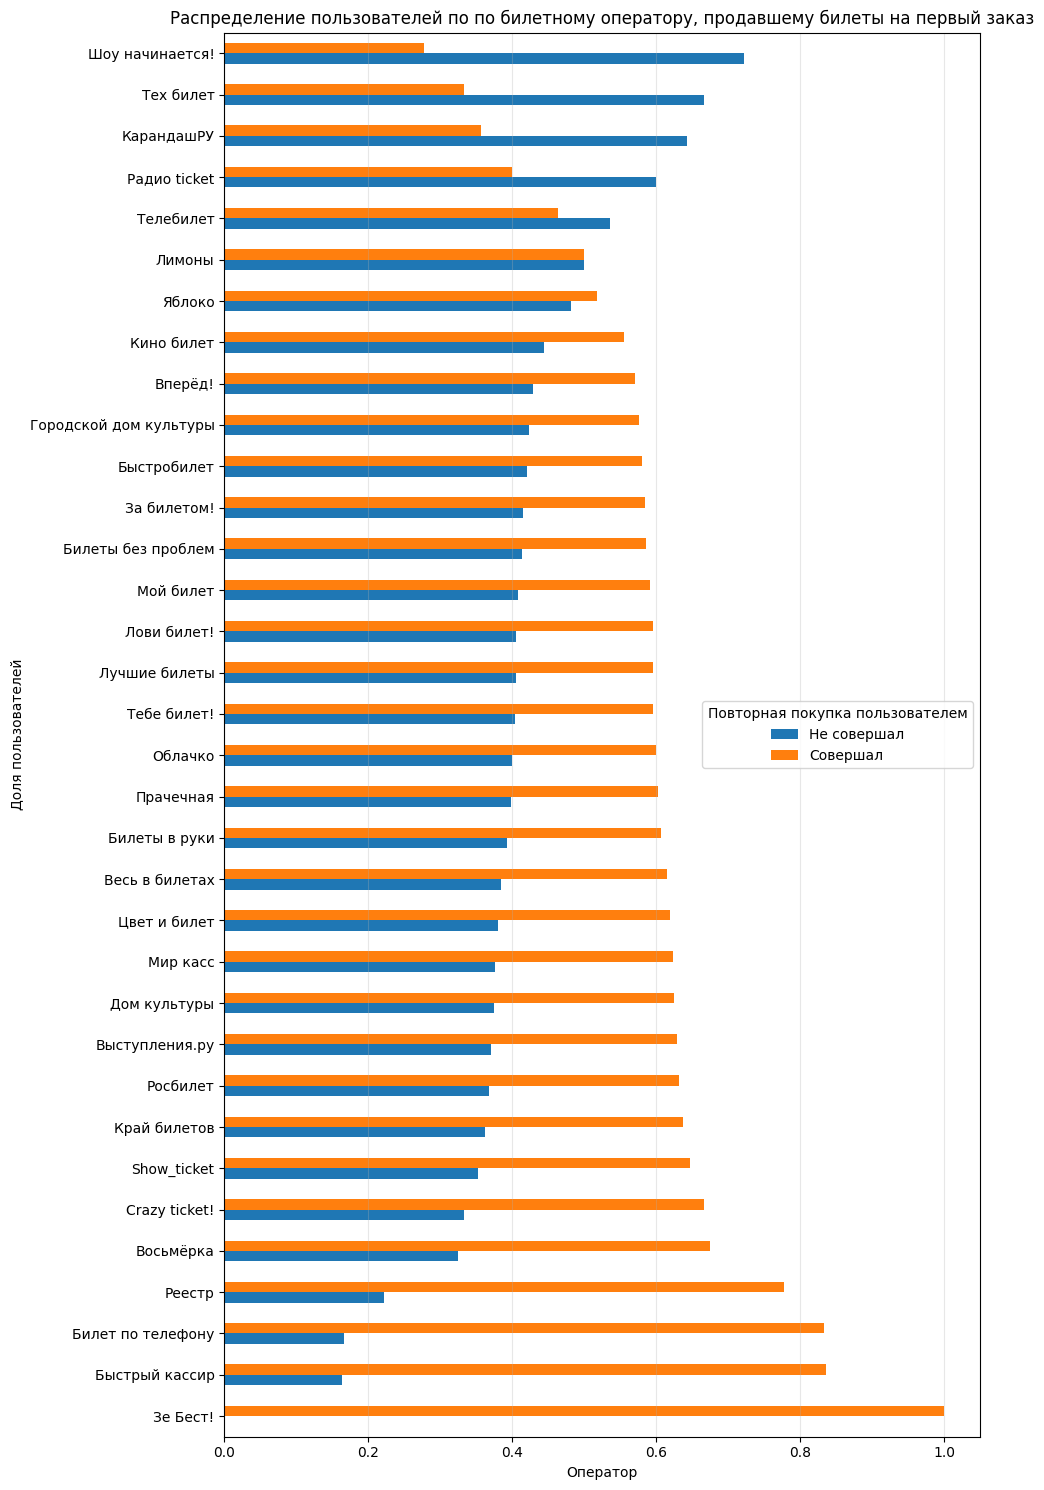

In [56]:
grouped = df_users3.groupby('first_service_name')['is_two'].value_counts(normalize=True).round(3).unstack(fill_value=0)
grouped = grouped.sort_values(by=True, ascending=False)

grouped.plot(kind='barh',
            title=f'Распределение пользователей по по билетному оператору, продавшему билеты на первый заказ',
            legend=True,
            ylabel='Доля пользователей',
            xlabel='Оператор',
            rot=0,
            figsize=(10, 15))
plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

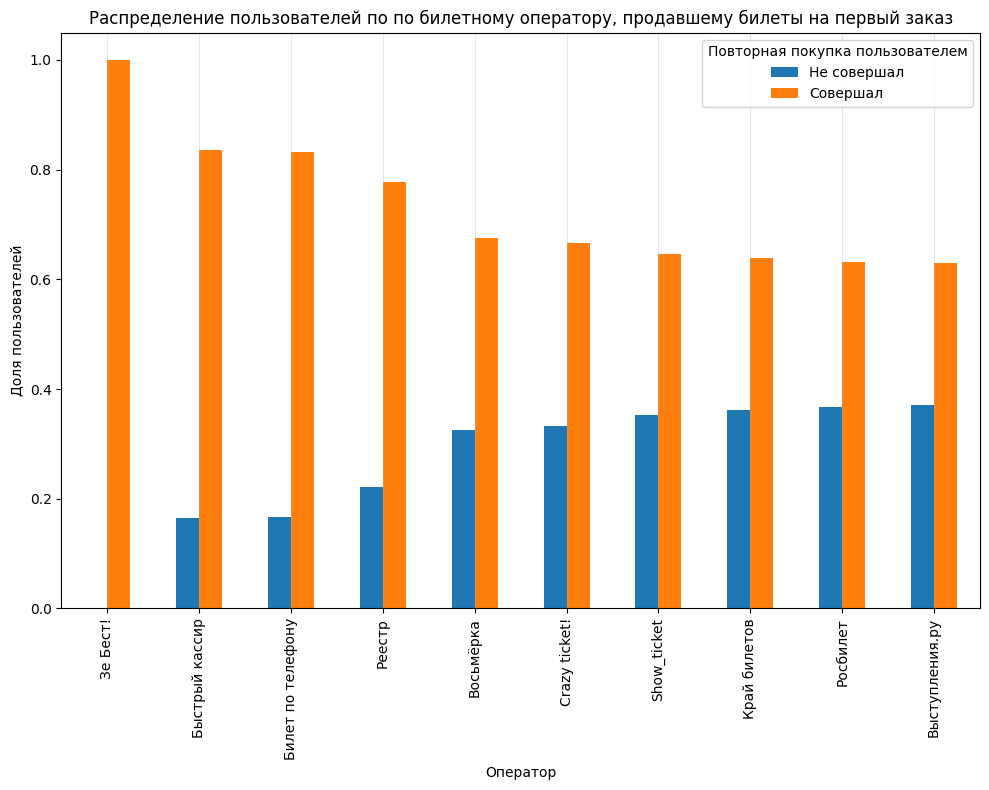

In [57]:
# Сегментов слишком много, для наглядности поместим на график только 10 сегментов с наибольшим количеством пользователей

grouped = df_users3.groupby('first_service_name')['is_two'].value_counts(normalize=True).round(3).unstack(fill_value=0)
grouped = grouped.sort_values(by=True, ascending=False).head(10)

grouped.plot(kind='bar',
            title=f'Распределение пользователей по по билетному оператору, продавшему билеты на первый заказ',
            legend=True,
            ylabel='Доля пользователей',
            xlabel='Оператор',
            rot=90,
            figsize=(10, 8))
plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Среди регионов первой покупки могут быть "точки входа": пользователи из Радужнопольского края, Озернопольской области и Верхозёрского края имеют существенно большую долю повторных покупок, стоит изучить их отдельно.

In [58]:
target_region = ['Радужнопольский край', 'Озернопольская область', 'Верхозёрский край']

filtered_df = df_users3[df_users3['first_order_region'].isin(target_region)]

grouped = filtered_df['first_order_region'].value_counts()
grouped = grouped.sort_values(ascending=False)
print(grouped)

first_order_region
Озернопольская область    26
Радужнопольский край      21
Верхозёрский край          1
Name: count, dtype: int64


В выборке всего 21854 пользователей; число пользователей, совершивших повторную покупку, в изучаемых регионах не является статистически значимым.
Рассмотрим регионы с наименьшей (нулевой) долей повторных покупок.

In [59]:
target_region = ['Яснопольский округ', 'Островогорский округ', 'Сосноводолинская область', 'Светолесский край']

filtered_df = df_users3[df_users3['first_order_region'].isin(target_region)]

grouped = filtered_df['first_order_region'].value_counts()
grouped = grouped.sort_values(ascending=False)
print(grouped)

first_order_region
Островогорский округ        4
Сосноводолинская область    1
Светолесский край           1
Яснопольский округ          1
Name: count, dtype: int64


Здесь аналогичная ситуация - число пользователей, совершивших покупку в данных регионах также не является статистически значимым.
Таким образом, точек входа среди регионов первой покупки не обнаружено.

Среди билетных операторов, продавших билеты на первый заказ, могут быть "точки входа": пользователи существенно чаще повторно покупали билеты у операторов Реестр, Билет по телефону, Быстрый кассир, Зе Бест!, стоит изучить их отдельно.

In [60]:
target_service = ['Реестр', 'Билет по телефону', 'Быстрый кассир', 'Зе Бест!']

filtered_df = df_users3[df_users3['first_service_name'].isin(target_service)]

grouped = filtered_df['first_service_name'].value_counts()
grouped = grouped.sort_values(ascending=False)
print(grouped)

first_service_name
Быстрый кассир       55
Реестр               27
Билет по телефону     6
Зе Бест!              1
Name: count, dtype: int64


Стоит дополнительно изучить покупки у оператора Быстрый кассир - хотя количество уникальных пользователей невелико, доля повторных заказов существенно больше, чем у операторов с сопоставимым количеством заказов, таких, как Шоу начинается!, Радио ticket и Телебилет.

---
Проверим продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Проверка гипотезы 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

In [61]:
repeat_rate_sport = df_users3[df_users3['first_event_type'] == 'спорт']['is_two'].mean()
print(f"Доля пользователей, совершивших первый заказ на спортивные мероприятия и совершивших повторный заказ: {repeat_rate_sport:.2%}")

repeat_rate_concert = df_users3[df_users3['first_event_type'] == 'концерты']['is_two'].mean()
print(f"Доля пользователей, совершивших первый заказ на концерты и совершивших повторный заказ: {repeat_rate_concert:.2%}")


Доля пользователей, совершивших первый заказ на спортивные мероприятия и совершивших повторный заказ: 54.30%
Доля пользователей, совершивших первый заказ на концерты и совершивших повторный заказ: 60.30%


Пользователи, которые совершили первый заказ на спортивные мероприятия, в среднем совершают повторный заказ даже чуть реже, чем пользователи, оформившие свой первый заказ на концерты, **гипотеза не подтвердилась.**

**Проверка гипотезы 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

In [62]:
# Разделим регионы на 2 категории по количеству пользователей - топ и остальные

region_counts = df_users3['first_order_region'].value_counts()
median_count = region_counts.median()

top_regions = region_counts[region_counts >= median_count].index.tolist()
other_regions = region_counts[region_counts < median_count].index.tolist()

df_users3['region_category'] = np.where(
    df_users3['first_order_region'].isin(top_regions),
    'top_regions',
    'other_regions'
)

print("Распределение пользователей по категориям регионов")
print("\nКоличество пользователей:")
print(df_users3['region_category'].value_counts())
print("\nДоли пользователей:")
print(df_users3['region_category'].value_counts(normalize=True).round(3))

print("\nСтатистика по повторным покупкам")
print("\nСредние значения (доли) пользователей, совершивших повторные покупки:")
top_mean = df_users3[df_users3['region_category'] == 'top_regions']['is_two'].mean()
other_mean = df_users3[df_users3['region_category'] == 'other_regions']['is_two'].mean()

print(f"Топ регионы:    {top_mean:.2%}")
print(f"Остальные:      {other_mean:.2%}")
print(f"Разница:        {top_mean - other_mean:.2%} (в {top_mean/other_mean:.2f} раза)")

Распределение пользователей по категориям регионов

Количество пользователей:
region_category
top_regions      20015
other_regions      746
Name: count, dtype: int64

Доли пользователей:
region_category
top_regions      0.964
other_regions    0.036
Name: proportion, dtype: float64

Статистика по повторным покупкам

Средние значения (доли) пользователей, совершивших повторные покупки:
Топ регионы:    59.91%
Остальные:      54.02%
Разница:        5.88% (в 1.11 раза)


C:\Users\Peter\AppData\Local\Temp\ipykernel_4080\3780454802.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users3['region_category'] = np.where(


В регионах, где больше всего пользователей посещают мероприятия, доля повторных заказов больше на 5,88%, чем в менее активных регионах. С учётом количества пользователей в категориях регионов, нельзя считать эту разницу статистически значимой, ***гипотеза не подтвердилась.***

#### Исследование поведения пользователей через показатели выручки и состава заказа

Изучим количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Проследим связь между средней выручкой сервиса с заказа и повторными заказами.

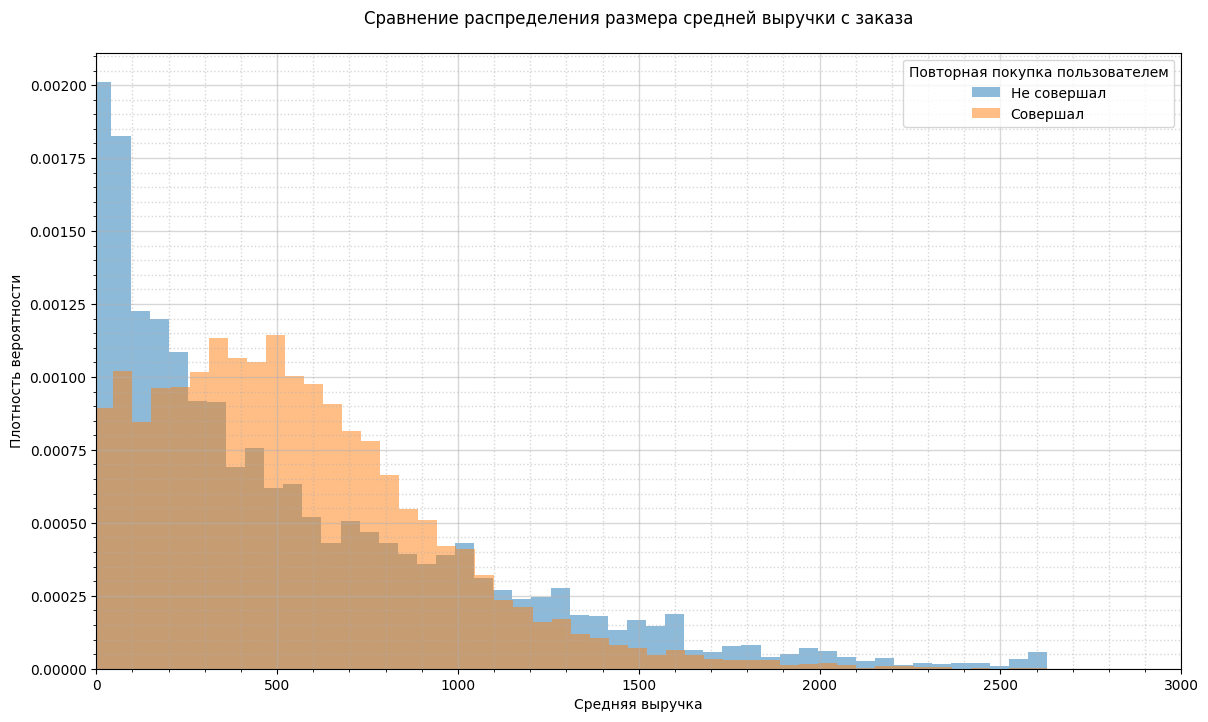

In [63]:
plt.figure(figsize=(14, 8))

for i in df_users3['is_two'].unique():
    df_users3.loc[df_users3['is_two'] == i, 'mean_revenue'].plot(
        kind='hist',
        density=True,
        bins=50,
        alpha=0.5
    )
    
plt.title(f'Сравнение распределения размера средней выручки с заказа\n')
plt.xlabel('Средняя выручка')
plt.ylabel('Плотность вероятности')
plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем')
plt.xlim(0, 3000)

#plt.grid()

plt.grid(True, which='major', alpha=0.5, linestyle='-', linewidth=1)
plt.grid(True, which='minor', alpha=0.5, linestyle=':', linewidth=1)

plt.minorticks_on()

plt.show()

Пользователи, не совершавшие повторные покупки, концентрируются в диапазоне средней выручки от 0 до 600 руб. с заказа. 

Пользователи, совершившие повторные покупки, концентрируются в диапазоне средней выручки от 0 до 800 руб. с заказа.
Доля пользователей, не совершавших повторные покупки, наибольшая при средней выручке до 100 руб. с заказа и с увеличением выручки резко уменьшается.

Доля пользователей, совершавших повторные покупки, наибольшая при средней выручке около 500 руб. с заказа, с увеличением выручки от 0 до 500 руб. также растёт, а после - уменьшается.

Оба графика показываетют правостороннее асимметричное распределение.

Разница между группами следующая: при средней выручке от 250 руб. до 1000 руб. с заказа вероятность того, что пользователь совершал повторную покупку, выше, при выручке около 500 руб. - статистически значимо.

Сравним распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

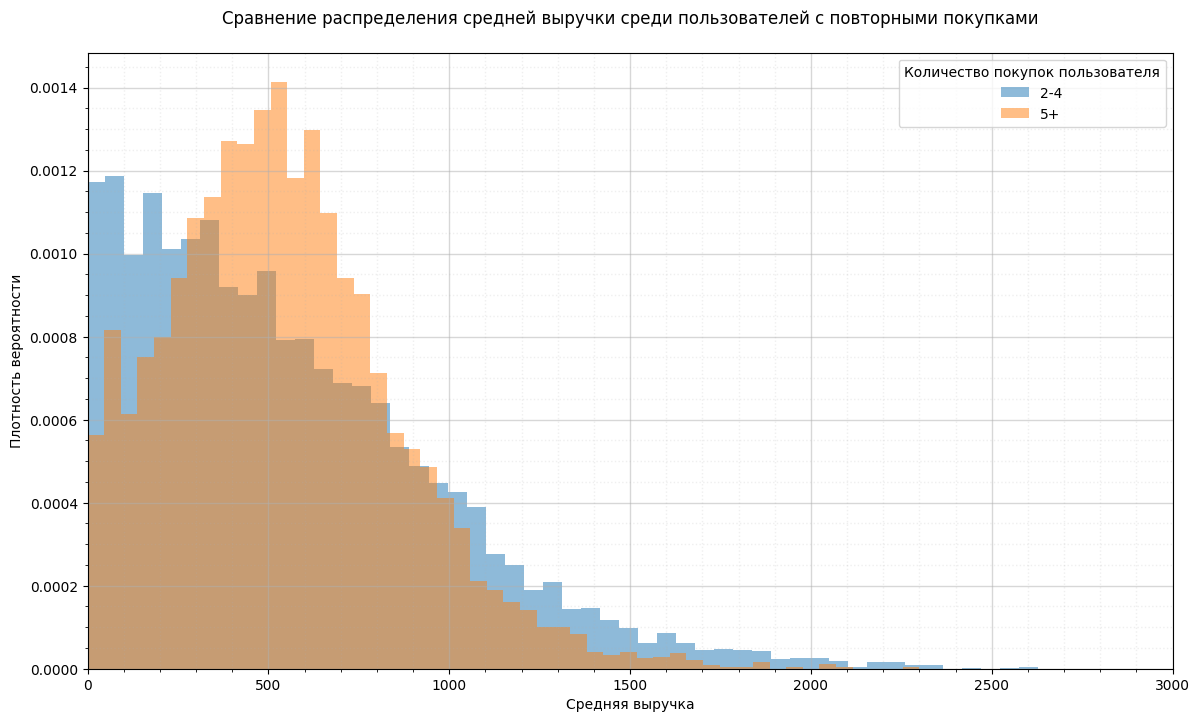

In [64]:
plt.figure(figsize=(14, 8))

df_is_two_true = df_users3[df_users3['is_two'] == True]

for i in df_is_two_true['is_five'].unique():
    subset = df_is_two_true[df_is_two_true['is_five'] == i]['mean_revenue'].plot(
    kind='hist',
    density=True,
    bins=50,
    alpha=0.5,
    linewidth=0.5)

plt.title('Сравнение распределения средней выручки среди пользователей с повторными покупками\n')
plt.xlabel('Средняя выручка')
plt.ylabel('Плотность вероятности')
plt.legend(['2-4', '5+'], title='Количество покупок пользователя')
plt.xlim(0, 3000)

plt.grid(True, which='major', alpha=0.5, linestyle='-', linewidth=1)
plt.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=1)

plt.minorticks_on()

plt.show()

Разница между группами пользователей, совершивших 2-4 покупки, и 5 и более, следующая: при средней выручке от 250 руб. до 800 руб. с заказа вероятность того, что пользователь совершил более 4 покупок, выше, при выручке около 500 руб. - статистически значимо.

---
Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе.
- Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитаем общее число пользователей и долю пользователей, совершивших повторные заказы.
- Определим, как распределены пользователи по сегментам.
---

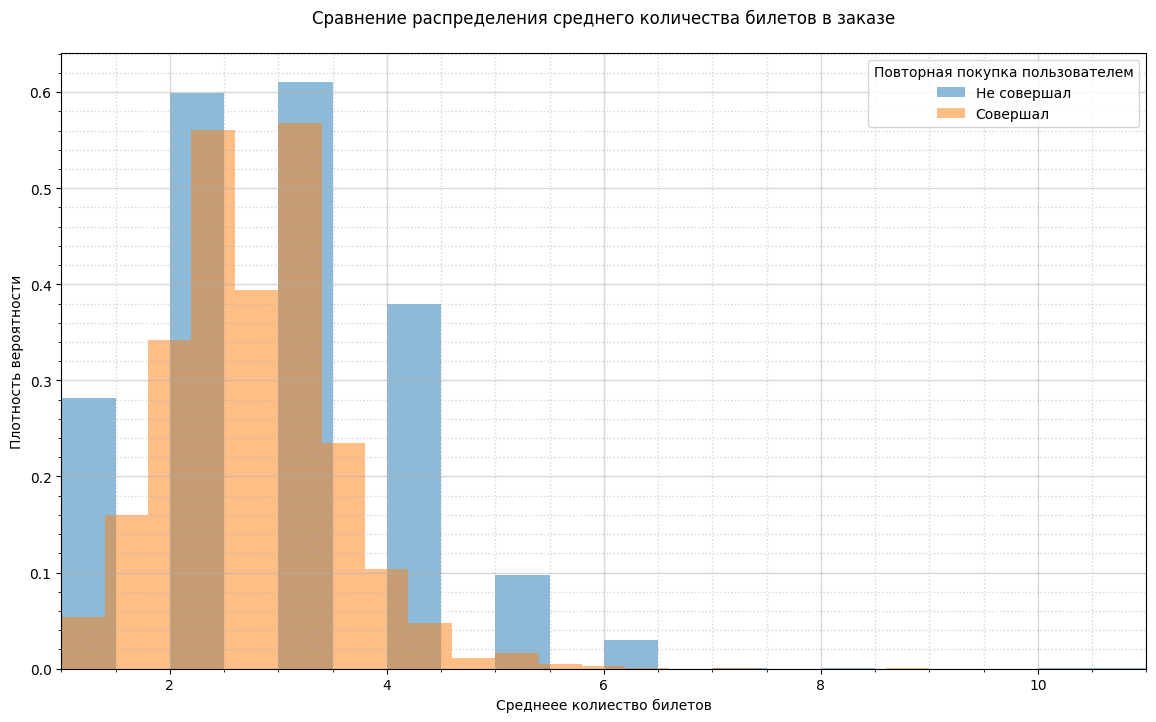

In [65]:
plt.figure(figsize=(14, 8))

for i in df_users3['is_two'].unique():
    df_users3.loc[df_users3['is_two'] == i, 'mean_tickets_count'].plot(
        kind='hist',
        density=True,
        bins=20,
        alpha=0.5
    )
    
plt.title(f'Сравнение распределения среднего количества билетов в заказе\n')
plt.xlabel('Среднеее колиество билетов')
plt.ylabel('Плотность вероятности')
plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем')
plt.xlim(1, 11)

plt.grid(True, which='major', alpha=0.5, linestyle='-', linewidth=1)
plt.grid(True, which='minor', alpha=0.5, linestyle=':', linewidth=1)

plt.minorticks_on()

plt.show()

Пользователи, совершившие повторные заказы, в среднем за заказ покупают билетов меньше, чем те, что сделали заказ единожды. Пользователи из обеих категорий чаще всего покупают 2-3 билета, но 1, а также 4 и более билетов пользователи, совершившие повторные покупки, покупают гораздо реже.

In [66]:
def segmentation(tickets):
    if tickets >= 1 and tickets < 2:
        return '1-2'
    elif tickets >= 2 and tickets < 3:
        return '2-3'
    elif tickets >= 3 and tickets < 5:
        return '3-5'
    elif tickets >= 5:
        return '5+'
    else:
        return None
    
df_users3['ticket_segment'] = df_users3['mean_tickets_count'].apply(segmentation)

segment_stats = df_users3.groupby('ticket_segment').agg(
    total_users=('is_two', 'size'),
    repeat_users=('is_two', 'sum')
).reset_index()

segment_stats['repeat_rate'] = segment_stats['repeat_users'] / segment_stats['total_users']

print("Сегменты пользователей по среднему количеству билетов в заказе:\n")
print(segment_stats[['ticket_segment', 'total_users', 'repeat_rate']])

Сегменты пользователей по среднему количеству билетов в заказе:

  ticket_segment  total_users  repeat_rate
0            1-2         2415     0.512215
1            2-3         8759     0.713552
2            3-5         8926     0.535738
3             5+          661     0.187595


C:\Users\Peter\AppData\Local\Temp\ipykernel_4080\1956225807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users3['ticket_segment'] = df_users3['mean_tickets_count'].apply(segmentation)


Пользователи распределены по сегментам неравномерно - купивших за заказ в среднем более 5 билетов существенно меньше, чем в прочих группах, также среди них самая маленькая доля повторно сделавших заказ.

#### Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

Проанализируем, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

In [67]:
df_users3.loc[:, 'day_of_week'] = df_users3['first_order_dt'].dt.dayofweek

print(f'\033[1mОбщее число пользователей по дням недели совершения первой покупки:\033[0m')
total = df_users3['day_of_week'].value_counts()
print(total, f'\n\nДоля в разрезе признака')
    
grouped = df_users3.groupby(['day_of_week'])['is_two'].value_counts(normalize=True).round(2).unstack(fill_value=0)
grouped = grouped.sort_values(by=True, ascending=False)
print(grouped)

Общее число пользователей по дням недели совершения первой покупки:
day_of_week
4    3166
5    3122
3    3027
1    3025
2    2960
0    2820
6    2641
Name: count, dtype: int64 

Доля в разрезе признака
is_two       False  True 
day_of_week              
0             0.38   0.62
2             0.39   0.61
1             0.40   0.60
5             0.40   0.60
4             0.41   0.59
3             0.42   0.58
6             0.42   0.58


C:\Users\Peter\AppData\Local\Temp\ipykernel_4080\3349655373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users3.loc[:, 'day_of_week'] = df_users3['first_order_dt'].dt.dayofweek


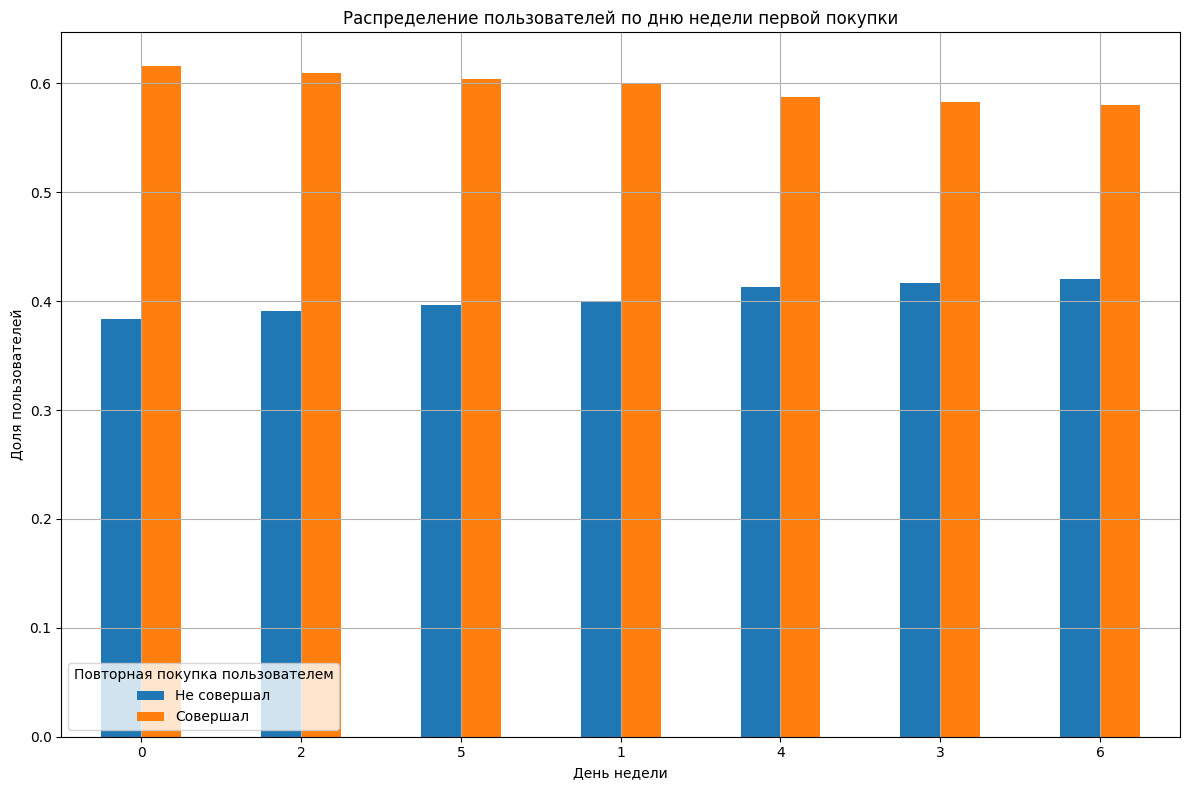

In [68]:
grouped = df_users3.groupby('day_of_week')['is_two'].value_counts(normalize=True).round(3).unstack(fill_value=0)
grouped = grouped.sort_values(by=True, ascending=False).head(10)

grouped.plot(kind='bar',
             title=f'Распределение пользователей по дню недели первой покупки',
             legend=True,
             ylabel='Доля пользователей',
             xlabel='День недели',
             rot=0,
             figsize=(12, 8))

plt.legend(['Не совершал', 'Совершал'], title='Повторная покупка пользователем', loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()

Количество пользователей по дням недели совершения первой покупки распределено достаточно равномерно; чуть меньше, чем в прочие дни, пользователей сделало первый заказ в понедельник.

Доли клиентов, совершивших повторную покупку, распределены по дня недели равномерно.

День недели, в который совершена первая покупка, не влияет на вероятность возврата клиента.

---
Изучим, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитаем среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуем, как средний интервал между заказами влияет на вероятность повторного заказа.
---

In [69]:
group_2_4 = df_users3[(df_users3['is_two'] == True) & (df_users3['is_five'] == False)]
group_5_plus = df_users3[(df_users3['is_two'] == True) & (df_users3['is_five'] == True)]

print(f"Размеры групп пользователей по количеству заказов:")
print(f"Пользователи с 2-4 заказами:  {len(group_2_4)} чел.")
print(f"Пользователи с 5+ заказами:   {len(group_5_plus)} чел.")

mean_time_2_4 = group_2_4['mean_days_since_prev'].mean().round(1)
mean_time_5_plus = group_5_plus['mean_days_since_prev'].mean().round(1)


print("\nСреднее время между заказами:")
print(f"Пользователи с 2-4 заказами: {mean_time_2_4} дней")
print(f"Пользователи с 5+ заказами:  {mean_time_5_plus} дней")
print(f"\nРазница: {abs(mean_time_2_4 - mean_time_5_plus).round(2)} дней")
print(f"Отношение: в {mean_time_2_4/mean_time_5_plus:.2f} раза {'дольше' if mean_time_2_4 > mean_time_5_plus else 'короче'}")

Размеры групп пользователей по количеству заказов:
Пользователи с 2-4 заказами:  7147 чел.
Пользователи с 5+ заказами:   5246 чел.

Среднее время между заказами:
Пользователи с 2-4 заказами: 21.3 дней
Пользователи с 5+ заказами:  11.1 дней

Разница: 10.2 дней
Отношение: в 1.92 раза дольше


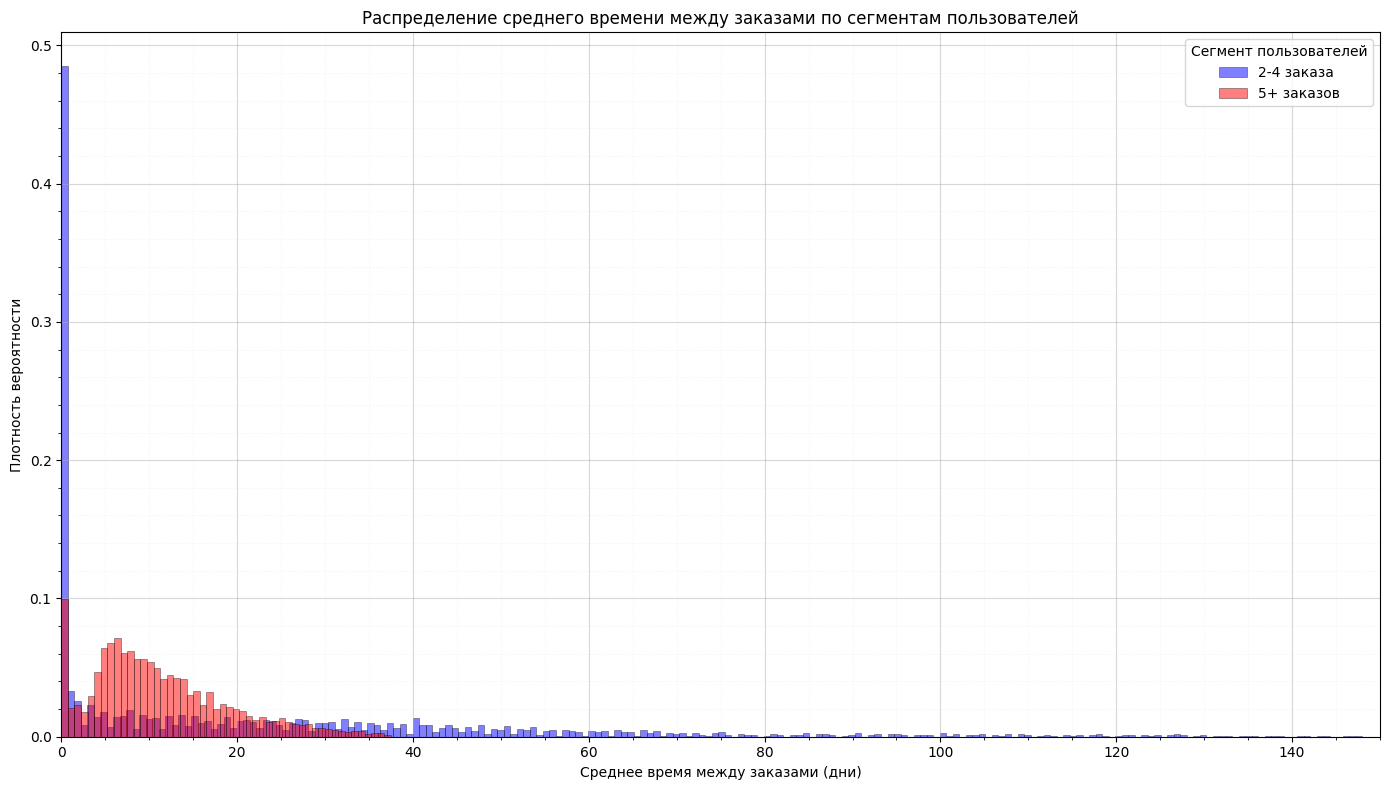

In [70]:
plt.figure(figsize=(14, 8))

plt.hist(group_2_4['mean_days_since_prev'].dropna(), 
         bins=200,
         density=True,
         alpha=0.5,
         color='blue',
         edgecolor='black',
         linewidth=0.5,
         label='2-4 заказа')

plt.hist(group_5_plus['mean_days_since_prev'].dropna(), 
         bins=50,
         density=True,
         alpha=0.5,
         color='red',
         edgecolor='black',
         linewidth=0.5,
         label='5+ заказов')

plt.title('Распределение среднего времени между заказами по сегментам пользователей')
plt.xlabel('Среднее время между заказами (дни)')
plt.ylabel('Плотность вероятности')
plt.legend(title='Сегмент пользователей')
plt.xlim(0, 150)

plt.grid(True, which='major', alpha=0.5, linestyle='-', linewidth=0.8)
plt.grid(True, which='minor', alpha=0.2, linestyle=':', linewidth=0.5)
plt.minorticks_on()

plt.tight_layout()
plt.show()

Для обоих интервалов сегментов пользователей самая высокая вероятность совершения повторной покупки в тот же день, который была сделана предыдущая.

Для пользователей, сделавших 2-4 заказа, эта вероятность гораздо выше, чем в любой другой период времени, и резко падает с увеличением интервала до 1-2 дней, а далее плавно снижается со временем.

Для пользователей, сделавших 5 и более заказов, вероятность совершения повторной покупки в тот же день, что и предыдущая, гораздо выше, чем в любой другой, на 1-2 день она снижается, а с 3 возрастает, и на 4-5 достигает значений, сопоставимых с наибольшей, после чего плавно снижается.

---

#### Корреляционный анализ количества покупок и признаков пользователя

Изучим, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок с помощью коэффициента корреляции `phi_k`.

---

In [71]:
# Строим корреляционную матрицу с использованием phi_k
interval_columns = ['orders_count', 'mean_revenue', 'mean_tickets_count', 'mean_days_since_prev']

correlation_matrix = df_users3[['first_order_dt', 'last_order_dt', 'first_order_device', 
                         'first_order_region', 'first_service_name', 'first_event_type',
                                'orders_count', 'mean_revenue', 'mean_tickets_count',
                                'mean_days_since_prev', 'is_two', 'is_five']].phik_matrix(interval_cols=interval_columns)

print('\nКорреляционная матрица с коэффициентом phi_k для переменной orders_count')
correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)


Корреляционная матрица с коэффициентом phi_k для переменной orders_count


,orders_count
is_five,0.986347
is_two,0.720260
mean_days_since_prev,0.490144
last_order_dt,0.399200
first_order_dt,0.398022
mean_tickets_count,0.296873
mean_revenue,0.265566
first_order_device,0.050899
first_service_name,0.040156
first_event_type,0.028651


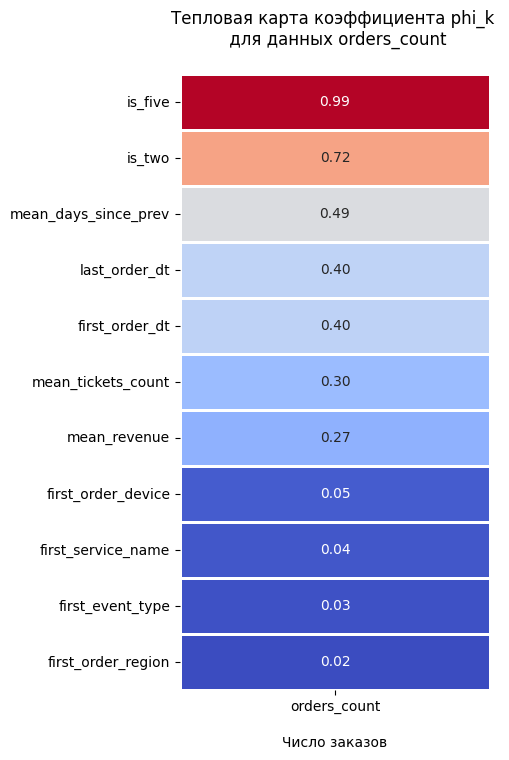

In [72]:
# Визуализируем корелляционную матрицу
plt.figure(figsize=(4, 8))

data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            linewidths=1, 
            cbar=False 
           )

plt.title('Тепловая карта коэффициента phi_k \n для данных orders_count\n')
plt.xlabel('\nЧисло заказов')
plt.show()

С числом заказов имеют сильную связь следующие признаки: сделал ли пользователь 5 заказов и более, сделал ли пользователь 2 заказа и более. Также умеренную связь имеют следующие признаки: среднее количество дней с предыдущего заказа, даты первого и последнего заказов. Также есть некоторая слабая связь со средним количеством билетов в заказе пользователя и средней выручкой с заказа. 

### Общий вывод и рекомендации

**Информация о данных**

Данные для работы представляли собой датасет из 14 столбцов и 290611 строк, в которых представлена информация об использовании платформы пользователями.

Некоторые заказы были оплачены пользователями в тенге, а другие в российский рублях, данные приведены к единой валюте - российскому рублю.

Данные имели выбросы и были отфильтрованы по стоимости заказа по 99 перцентилю (было отфильтровано 0.97% данных) и по количеству заказов пользователя по 95 перцентилю (отфильтровано 5% пользователей).

**Основные результаты анализа.**

В выборке всего 20761 пользователей.
Cредняя выручка с одного заказ пользователя составляет 546.68 руб.
Доля пользователей с 2 заказами и более составляет 59.69%
Доля пользователей с 5 заказами и более составляет 25.27%

C возвраом пользователя имеет умеренную связь дата первого заказа - чем раньше был совершён заказ, тем выше вероятность, что за прошедшее время пользователь вернулся.

Средняя выручка и количество билетов в заказе с вероятностью повторных покупок связаны слабо.

Стоит дополнительно изучить покупки у оператора Быстрый кассир - хотя количество уникальных пользователей невелико, доля повторных заказов существенно больше, чем у операторов с сопоставимым количеством заказов.

День недели первой покупки пользователя не влияет на то, будет ли он совершать покупки в будущем.
Наиболее значимая и ярко выраженная зависимость, выявленная в исследовании - зависимость интервала между заказами: повторный заказ вне зависимости от будущего количества совершается в тот же день, что и предыдущий (первый для пользователей, совершивших 2 заказа).
    
Согласно результатам корреляционного анализа, с числом покупок могут быть связаны следующие характеристики первого заказа и профиля пользователя: дата первого заказа, количество билетов в заказе и выручка с заказа.

**Ячейка для ссылки на публикацию в Git**